Import Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

Load Dataset

In [98]:
data = pd.read_csv("Creditcard_data.csv")
data['Class'].value_counts()


Class
0    763
1      9
Name: count, dtype: int64

Visualize Class Imbalance

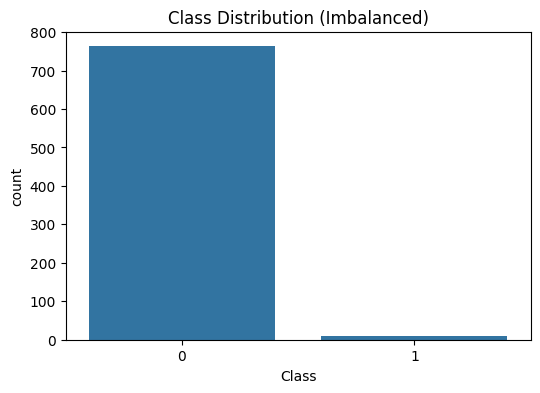

In [99]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Class Distribution (Imbalanced)")
plt.show()

Balanced Dataset using SMOTE

In [100]:
from imblearn.over_sampling import SMOTE

X = data.drop('Class', axis=1)
y = data['Class']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

balanced_data = pd.concat(
    [pd.DataFrame(X_balanced, columns=X.columns),
     pd.Series(y_balanced, name='Class')],
    axis=1
)

balanced_data['Class'].value_counts()


Class
0    763
1    763
Name: count, dtype: int64

Feature & Target Split

In [101]:
X = data.drop('Class', axis=1)
y = data['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train-Test Split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

Sampling Techniques

In [ ]:
# Sampling 1: Simple Random Sampling
sample1 = data.sample(frac=0.5, random_state=42)

# Sampling 2: Cross-Validation Systematic Sampling
# (This is just a placeholder; systematic sampling is not typically done via train_test_split)

# Sampling 3: Stratified Sampling
sample3, _ = train_test_split(
    data,
    test_size=0.5,
    stratify=data['Class'],
    random_state=42
)

# Sampling 4: Cluster Sampling
data_clustered = data.copy()
data_clustered['cluster'] = data_clustered.index % 5
sample4 = data_clustered[data_clustered['cluster'] == 2].drop('cluster', axis=1)

# Sampling 5: Bootstrap Sampling
sample5 = data.sample(frac=1, replace=True, random_state=42)


Visual Comparison of Samples

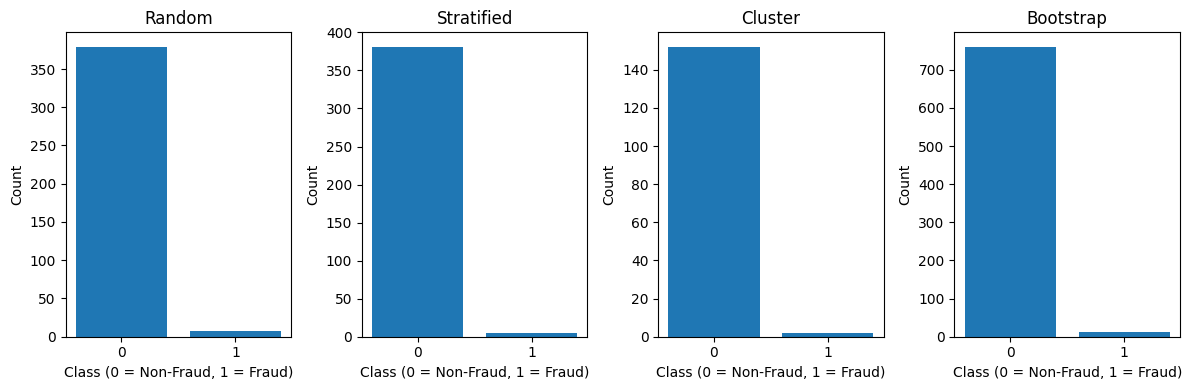

In [90]:
samples = [sample1, sample3, sample4, sample5]
titles = ["Random", "Stratified", "Cluster", "Bootstrap"]

plt.figure(figsize=(12,4))

for i, s in enumerate(samples):
    plt.subplot(1, 4, i + 1)
    class_counts = s['Class'].value_counts().sort_index()
    plt.bar(class_counts.index.astype(str), class_counts.values)
    plt.title(titles[i])
    plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


Models

In [91]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(class_weight='balanced'),
    "Naive Bayes": GaussianNB()
}

Evaluation Function

In [92]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def evaluate_model(X, y, model):

    class_counts = Counter(y)

    if min(class_counts.values()) < 2:
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
    else:
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xte = scaler.transform(Xte)

    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    return accuracy_score(yte, pred)



Apply Sampling × Models

In [93]:
from collections import Counter
import numpy as np

results = pd.DataFrame(index=models.keys(), columns=titles)

for model_name, model in models.items():
    for sample, title in zip(samples, titles):

        Xs = sample.drop('Class', axis=1)
        ys = sample['Class']

        # Skip only if a class is completely missing
        if len(Counter(ys)) < 2:
            results.loc[model_name, title] = np.nan
            continue

        acc = evaluate_model(Xs, ys, model)
        results.loc[model_name, title] = round(acc * 100, 2)


#Cross-Validation Evaluation Function
def evaluate_model_cv(X, y, model, n_splits=5):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in skf.split(X, y):
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)

        model.fit(Xtr, ytr)
        pred = model.predict(Xte)

        scores.append(accuracy_score(yte, pred))

    return np.mean(scores)


Result Table

In [94]:
titles = ["Random", "Cross-Validation", "Stratified", "Cluster", "Bootstrap"]
results = pd.DataFrame(index=models.keys(), columns=titles)

for model_name, model in models.items():

    # Random
    Xs = sample1.drop('Class', axis=1)
    ys = sample1['Class']
    results.loc[model_name, "Random"] = round(
        evaluate_model(Xs, ys, model) * 100, 2
    )

    # Cross-Validation (FULL DATASET)
    X = data.drop('Class', axis=1)
    y = data['Class']
    results.loc[model_name, "Cross-Validation"] = round(
        evaluate_model_cv(X, y, model) * 100, 2
    )

    # Stratified
    Xs = sample3.drop('Class', axis=1)
    ys = sample3['Class']
    results.loc[model_name, "Stratified"] = round(
        evaluate_model(Xs, ys, model) * 100, 2
    )

    # Cluster
    Xs = sample4.drop('Class', axis=1)
    ys = sample4['Class']
    results.loc[model_name, "Cluster"] = round(
        evaluate_model(Xs, ys, model) * 100, 2
    )

    # Bootstrap
    Xs = sample5.drop('Class', axis=1)
    ys = sample5['Class']
    results.loc[model_name, "Bootstrap"] = round(
        evaluate_model(Xs, ys, model) * 100, 2
    )

results = results.astype(float)
results


,Random,Cross-Validation,Stratified,Cluster,Bootstrap
Logistic Regression,98.28,98.70,98.28,97.87,97.84
Decision Tree,96.55,97.80,95.69,91.49,98.71
Random Forest,98.28,98.83,98.28,97.87,100.00
Support Vector Machine,94.83,96.12,98.28,97.87,96.98
Naive Bayes,93.97,95.47,95.69,97.87,92.67


Heatmap Visualization

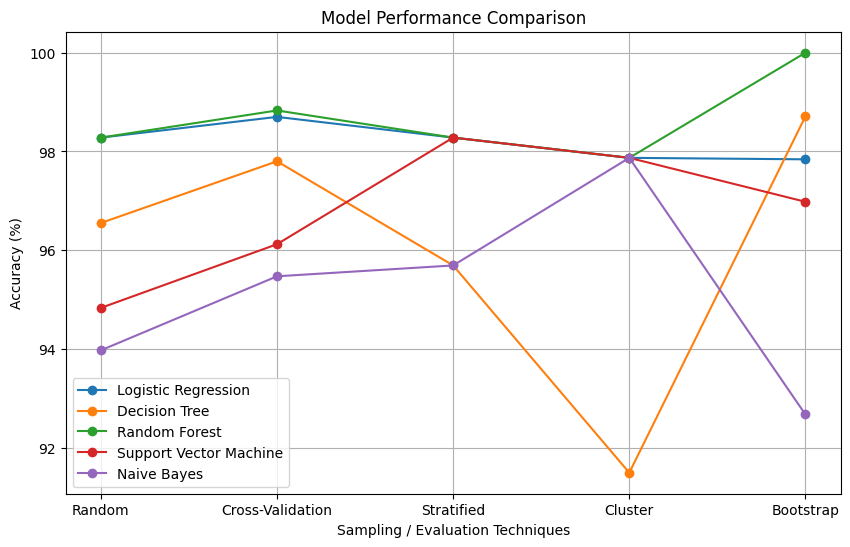

In [95]:
plt.figure(figsize=(10,6))

for model_name in results.index:
    plt.plot(
        results.columns,
        results.loc[model_name],
        marker='o',
        label=model_name
    )

plt.xlabel("Sampling / Evaluation Techniques")
plt.ylabel("Accuracy (%)")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()
